In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/UoA-eResearch/mussels/blob/main/EDA.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [33]:
%load_ext autotime
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import cv2
import matplotlib.pyplot as plt # Plotting
plt.rcParams['figure.figsize'] = [10, 10]
import numpy as np # Numeric data
import pandas as pd # Tabular data
from rasterio.features import shapes # Vectorising rasters to polygons
from shapely import Point, LineString, Polygon # Geometry
from shapely.geometry import box, shape
from shapely.ops import nearest_points
import geopandas as gpd # Plotting polygons
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


In [34]:
checkpoint = 'sam_vit_h_4b8939.pth'
sam = sam_model_registry['vit_h'](checkpoint=checkpoint)
# SAM takes 1 min 18 s on a CPU and 15.6s on a P40 GPU, so best to use a GPU
device = 'cuda:0'
sam.to(device)
print("SAM loaded")

SAM loaded


In [56]:
img = cv2.cvtColor(cv2.imread('EX4_ID/D1/IMG_7505.JPEG'), cv2.COLOR_BGR2RGB)
masks = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32, # The number of points to be sampled along one side of the image
    min_mask_region_area=100, # If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area
).generate(img)

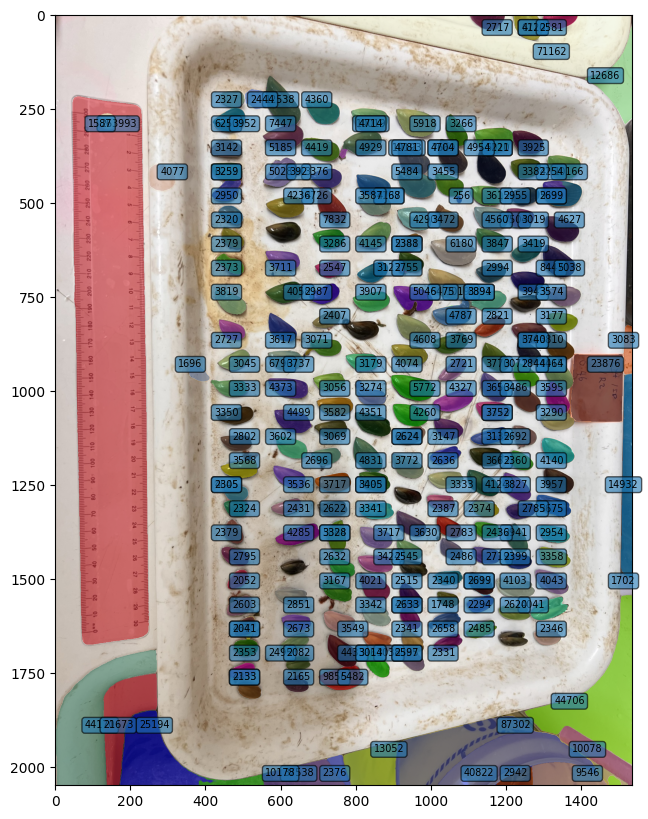

In [57]:
plt.imshow(img)
show_anns(masks)

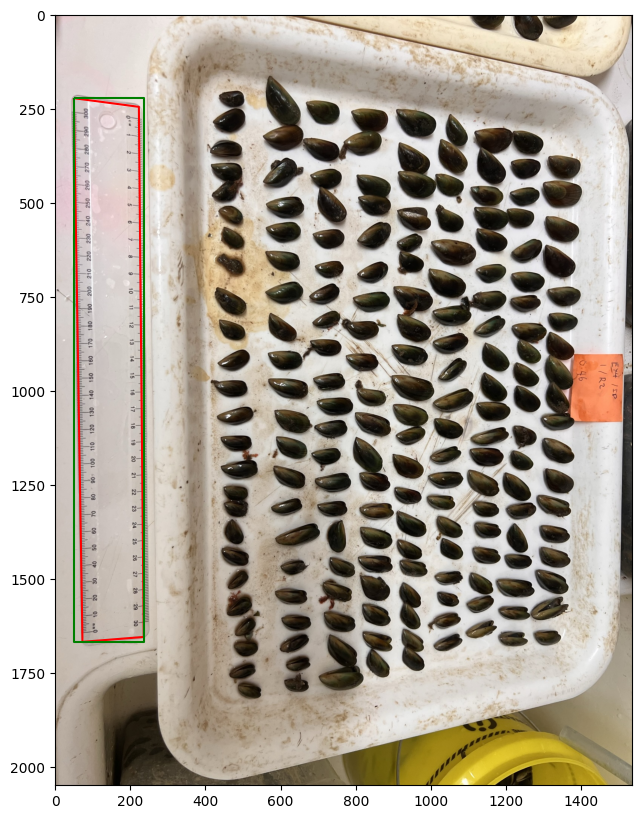

[[ 1.02740274e+00 -1.82477649e-02  1.89967137e+00]
 [-1.54690945e-01  9.24060226e-01  2.11646184e+01]
 [-1.39950865e-04 -3.58929668e-05  1.00000000e+00]]


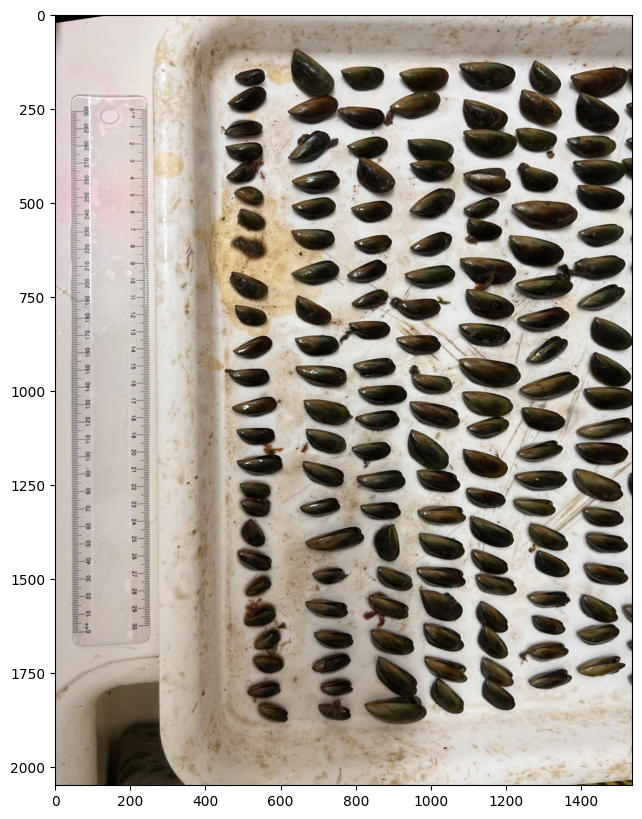

In [35]:
# Reproject trapezoidal tray to rectangular (rectify)
def snap(g1, g2, threshold=1e6):
    coordinates = []
    for x, y in g1.coords:  # for each vertex in the first line
        point = Point(x, y)
        p1, p2 = nearest_points(point, g2)  # find the nearest point on the second line
        if p1.distance(p2) <= threshold:
            # it's within the snapping tolerance, use the snapped vertex
            coordinates.append(p2.coords[0])
        else:
            # it's too far, use the original vertex
            coordinates.append((x, y))
    # convert coordinates back to a LineString and return
    return LineString(coordinates)

img = cv2.cvtColor(cv2.imread('EX4_ID/D1/IMG_7505.JPEG'), cv2.COLOR_BGR2RGB)
masks = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32, # The number of points to be sampled along one side of the image
    min_mask_region_area=100, # If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area
).generate(img)
tray = max(masks, key=lambda x: x["area"])
# Convert binary mask to polygon
tray = gpd.GeoSeries(shape(s) for s, v in shapes(tray["segmentation"].astype(np.uint8), mask=tray["segmentation"])).unary_union
plt.imshow(img)
trapezoid = snap(tray.envelope.exterior, tray)
bounds = trapezoid.envelope.exterior
gpd.GeoSeries(trapezoid).plot(ax=plt.gca(), color="red")
gpd.GeoSeries(bounds).plot(ax=plt.gca(), color="green")
plt.show()
source_corners = np.float32(trapezoid.coords[:4])
target_corners = np.float32(bounds.coords[:4])
matrix = cv2.getPerspectiveTransform(source_corners, target_corners)
print(matrix)
img = cv2.warpPerspective(img, matrix, (img.shape[1], img.shape[0]), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
plt.imshow(img)

In [36]:
masks = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=50, # The number of points to be sampled along one side of the image
    min_mask_region_area=100, # If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area
).generate(img)
len(masks)

218

In [37]:
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 297202,
 'bbox': [41.0, 213.0, 212.0, 1462.0],
 'predicted_iou': 1.0122803449630737,
 'point_coords': [[230.40000000000003, 1658.88]],
 'stability_score': 0.9810612797737122,
 'crop_box': [0, 0, 1536, 2048]}

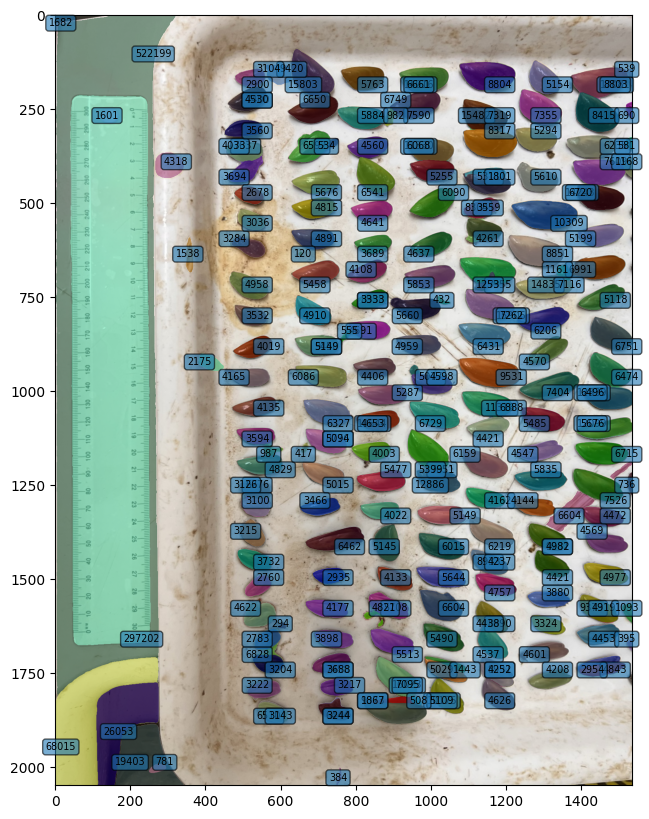

In [38]:
def show_anns(anns, alpha=.5):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [alpha]])
        img[m] = color_mask
        x, y = ann["point_coords"][0]
        plt.text(s=ann["area"], x=x, y=y, ha='center', va='center', bbox=dict(boxstyle="round", alpha=.6), fontsize="x-small")
    ax.imshow(img)

plt.imshow(img)
show_anns(masks)

In [39]:
masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
full_mask = np.zeros_like(masks[0]["segmentation"]).astype(int)
for i in range(len(masks)):
   x, y = np.where(masks[i]['segmentation'])
   full_mask[x,y] = i + 1

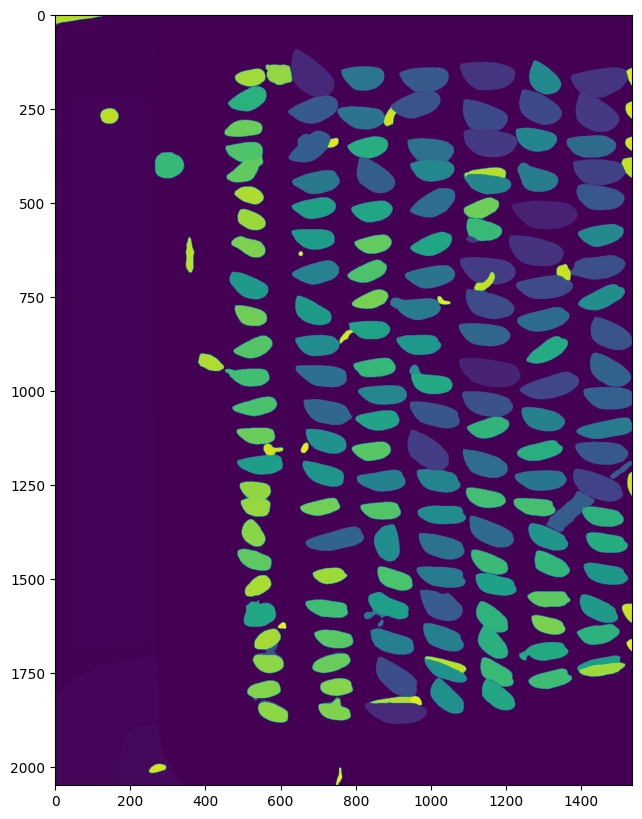

In [40]:
plt.imshow(full_mask)

In [41]:
# Vectorise raster
shape_gen = ((shape(s), v) for s, v in shapes(full_mask.astype(np.uint8), mask=full_mask>0))
# Convert shapes to GeoDataFrame, taking CRS from the image
df = gpd.GeoDataFrame(dict(zip(["geometry", "id"], zip(*shape_gen))))
df

geometry     id
0     POLYGON ((0.000 0.000, 0.000 27.000, 3.000 27....  195.0
1     POLYGON ((654.000 96.000, 654.000 97.000, 655....    9.0
2     POLYGON ((657.000 98.000, 657.000 99.000, 658....    9.0
3     POLYGON ((678.000 111.000, 678.000 112.000, 67...    9.0
4     POLYGON ((630.000 113.000, 630.000 114.000, 63...    9.0
...                                                 ...    ...
1527  POLYGON ((271.000 1992.000, 284.000 1992.000, ...  205.0
1528  POLYGON ((255.000 1708.000, 268.000 1708.000, ...    3.0
1529  POLYGON ((756.000 2001.000, 758.000 2001.000, ...  216.0
1530  POLYGON ((253.000 1886.000, 264.000 1886.000, ...    5.0
1531  POLYGON ((264.000 1775.000, 270.000 1775.000, ...    4.0

[1532 rows x 2 columns]

<Axes: >

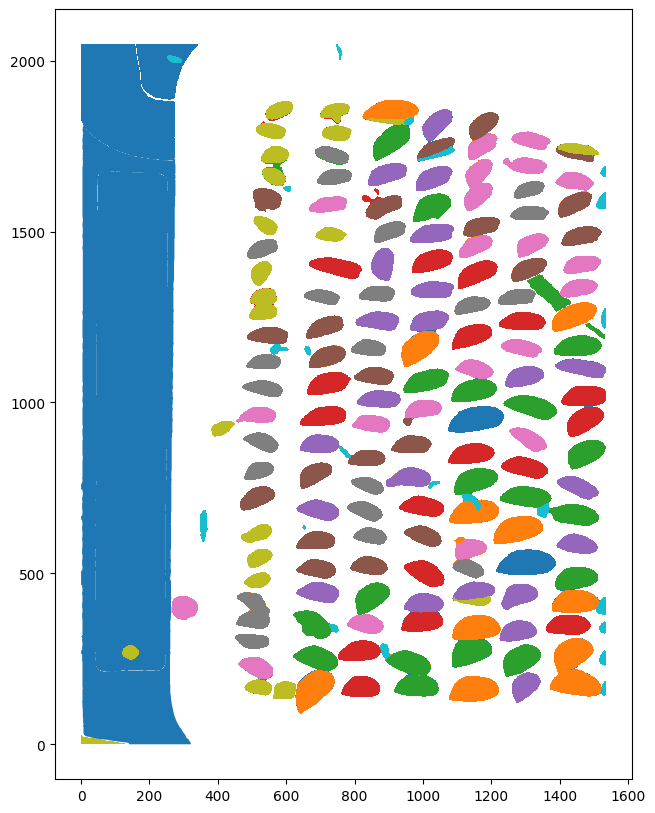

In [42]:
df.plot(column="id", categorical=True)

In [43]:
df["area"] = df.area

<Axes: >

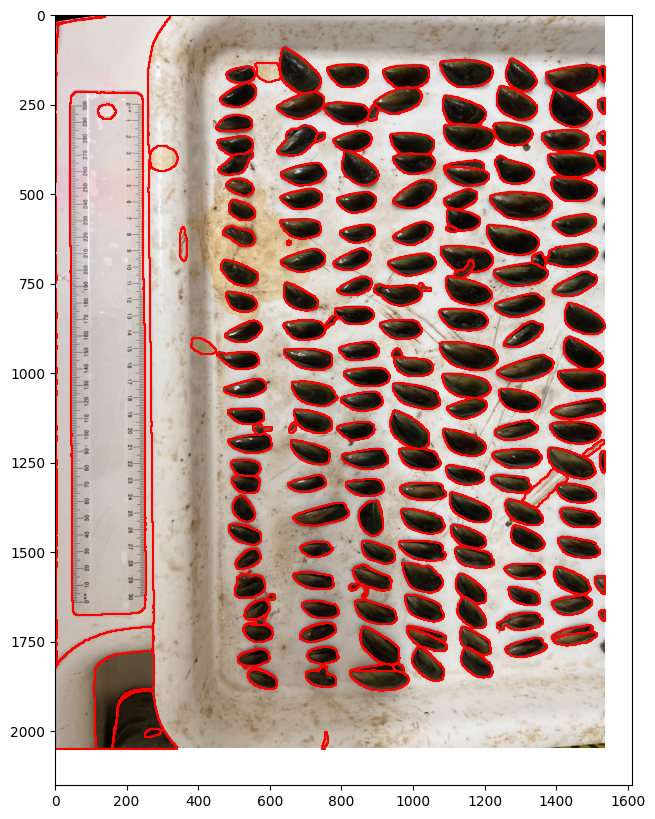

In [44]:
plt.imshow(img)
df.boundary.plot(color="red", ax=plt.gca())

In [45]:
df = df.sort_values(by="area", ascending=False)
df

geometry    id      area
1135  POLYGON ((64.000 213.000, 73.000 213.000, 73.0...   2.0  295601.0
1424  POLYGON ((140.000 0.000, 321.000 0.000, 321.00...   1.0  160350.0
1528  POLYGON ((255.000 1708.000, 268.000 1708.000, ...   3.0   42507.0
1531  POLYGON ((264.000 1775.000, 270.000 1775.000, ...   4.0   26053.0
1530  POLYGON ((253.000 1886.000, 264.000 1886.000, ...   5.0   18622.0
...                                                 ...   ...       ...
868   POLYGON ((566.000 1326.000, 566.000 1327.000, ...  74.0       1.0
869   POLYGON ((513.000 1327.000, 513.000 1328.000, ...  74.0       1.0
870   POLYGON ((515.000 1328.000, 515.000 1329.000, ...  74.0       1.0
871   POLYGON ((518.000 1329.000, 518.000 1330.000, ...  74.0       1.0
766   POLYGON ((687.000 1150.000, 687.000 1151.000, ...  35.0       1.0

[1532 rows x 3 columns]

<Axes: >

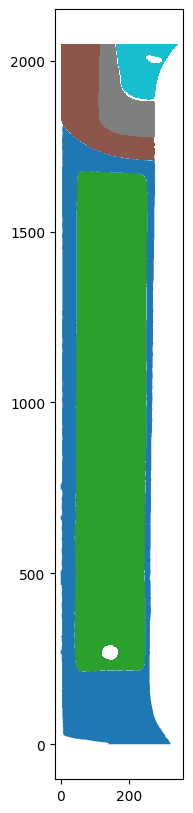

In [46]:
df.head(5).plot(column="id", categorical=True)

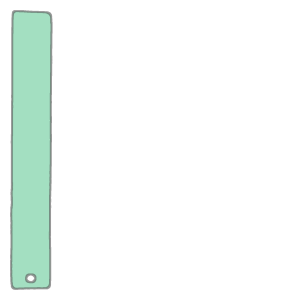

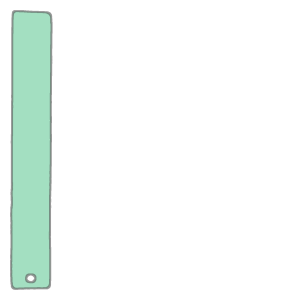

In [47]:
# Tray is largest, then the desk, then the ruler
tray = df.iloc[0]
display(tray.geometry)
# The ruler will be one of the top largest objects by area, and it's aspect ratio will be low (width much less than height)
def find_ruler(df):
  for i, row in df.iterrows():
    x1, y1, x2, y2 = row.geometry.bounds
    width = x2 - x1
    height = y2 - y1
    ratio = width / height
    if ratio < .15:
      return row

ruler = find_ruler(df)
display(ruler.geometry)

In [48]:
x1, y1, x2, y2 = ruler.geometry.bounds
ruler_height = y2 - y1
# pixels to cm conversion. ruler is 32cm long
px_per_cm = ruler_height / 32
px_per_cm

45.71875

In [49]:
df["centroid"] = df.centroid

In [50]:
df.iloc[0].centroid.coords[0]

(147.00381426314524, 948.5639307715468)

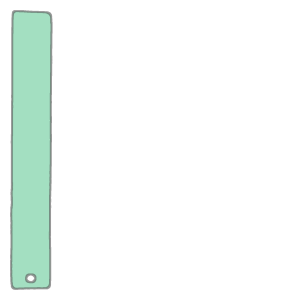

In [51]:
tray.geometry

In [52]:
def get_dimensions(geom):
    x1, y1, x2, y2 = geom.bounds
    width = x2 - x1
    height = y2 - y1
    return width, height

width, height = get_dimensions(tray.geometry)
width, height

(213.0, 1463.0)

/mnt/nid_env/lib/python3.8/site-packages/geopandas/plotting.py:409: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


0it [00:00, ?it/s]

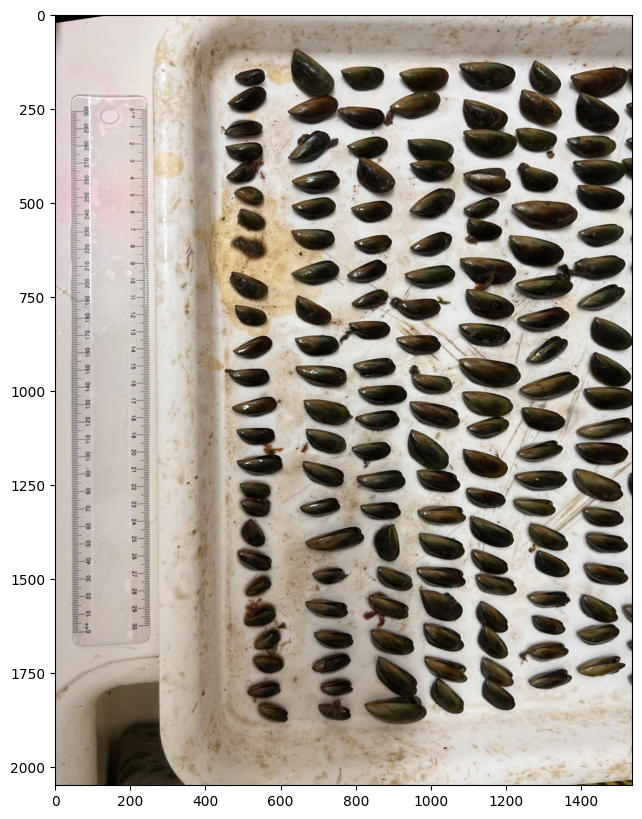

In [53]:
# Filter to just shapes in the tray
tray_edge_buffer = height * .03
area_threshold = height * .5
df = df[df.within(tray.geometry.envelope.buffer(-tray_edge_buffer)) & (df.area > area_threshold)]
plt.imshow(img)
df.boundary.plot(ax=plt.gca(), color="red")
for i, row in tqdm(df.iterrows()):
  plt.annotate(round(row.area), row.centroid.coords[0], color="white", fontsize="x-small")

In [54]:
df

Empty GeoDataFrame
Columns: [geometry, id, area, centroid]
Index: []

In [55]:
sample = df.sample(1)
poly = sample.geometry.iloc[0]
poly

ValueError: a must be greater than 0 unless no samples are taken

In [ ]:
# Get diameter of polygon by brute force, checking each point pair
def get_diameter(poly):
    max_dist = 0
    coords = [Point(x,y) for x,y in poly.exterior.coords]
    result_coords = []
    for i, a in enumerate(coords):
        for j, b in enumerate(coords):
            if i < j:
                dist = a.distance(b)
                if dist > max_dist:
                    max_dist = dist
                    result_coords = [a, b]

    line = LineString(result_coords)
    return line

line = get_diameter(poly)
line, line.length

(<LINESTRING (1299 571, 1204 555)>, 96.33794683301072)

Text(1251.5, 563.0, '96.34px')

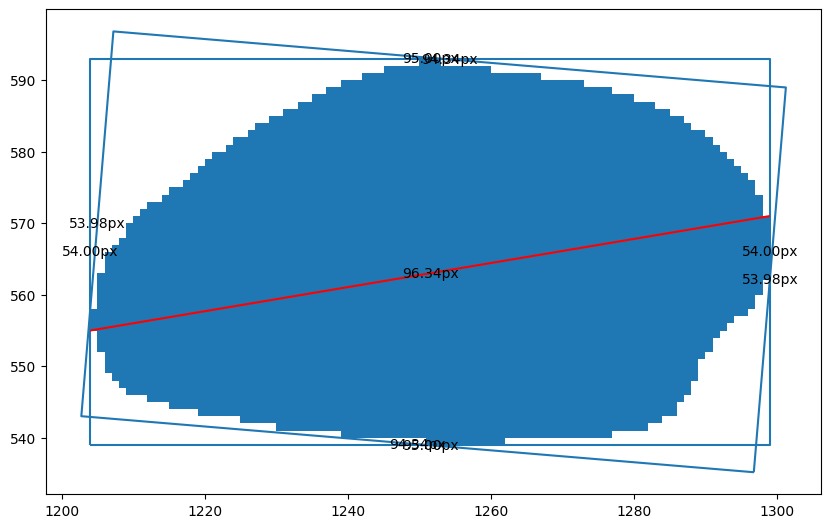

In [ ]:
def get_dist(a, b):
    return Point(a).distance(Point(b))

def midpoint(a, b):
    return ((a[0]+b[0])/2, (a[1]+b[1])/2)

def annotate_dist(poly):
    coords = list(poly.exterior.coords)
    for i in range(len(coords)-1):
        a, b = coords[i], coords[i+1]
        dist = get_dist(a, b)
        plt.annotate(f"{dist:.2f}px", xy=midpoint(a, b), ha='center', va='center')

mrr = poly.minimum_rotated_rectangle
bbox = poly.envelope
line = get_diameter(poly)

ax = gpd.GeoSeries([poly, mrr.exterior, bbox.exterior]).plot()
gpd.GeoSeries(line).plot(color="red", ax=ax)
annotate_dist(bbox)
annotate_dist(mrr)
plt.annotate(f"{line.length:.2f}px", xy=midpoint(*list(line.coords)), ha='center', va='center')

In [ ]:
df["diameter_line"] = df.geometry.progress_apply(get_diameter)
df["diameter_line"]

  0%|          | 0/77 [00:00<?, ?it/s]

/mnt/nid_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


197      LINESTRING (602.000 381.000, 478.000 300.000)
426      LINESTRING (611.000 480.000, 489.000 424.000)
459    LINESTRING (1101.000 507.000, 1000.000 424.000)
598      LINESTRING (625.000 566.000, 500.000 553.000)
199     LINESTRING (1108.000 382.000, 990.000 349.000)
                            ...                       
763      LINESTRING (410.000 654.000, 438.000 705.000)
571       LINESTRING (137.000 584.000, 98.000 554.000)
462      LINESTRING (402.000 483.000, 388.000 524.000)
417      LINESTRING (833.000 496.000, 802.000 451.000)
62     LINESTRING (1343.000 144.000, 1338.000 173.000)
Name: diameter_line, Length: 77, dtype: geometry

In [ ]:
ruler.diameter_line = get_diameter(ruler.geometry)

  0%|          | 0/77 [00:00<?, ?it/s]

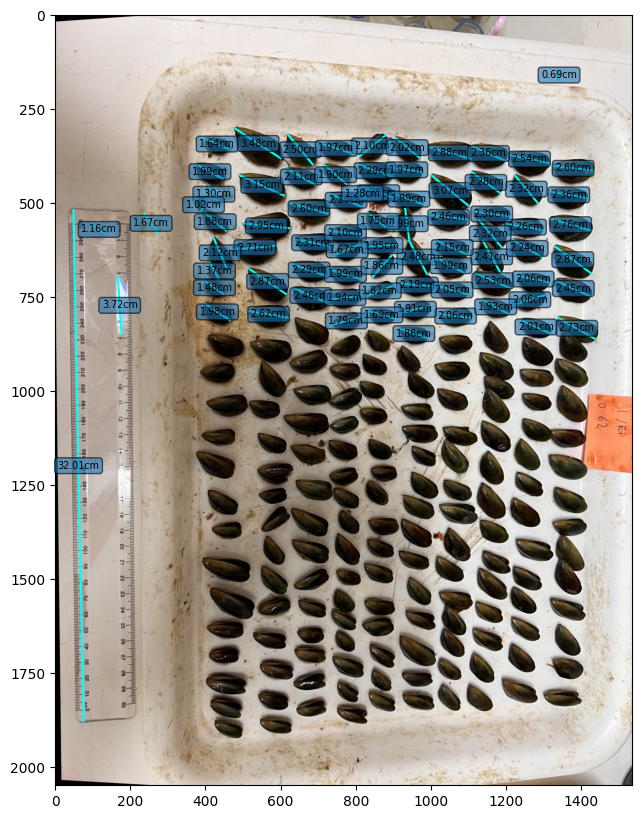

In [ ]:
def annotate_length(line):
    x, y = midpoint(*list(line.coords))
    plt.text(s=f"{line.length/px_per_cm:.2f}cm", x=x, y=y, ha='center', va='center', bbox=dict(boxstyle="round", alpha=.6), fontsize="x-small")

plt.imshow(img)
ax = plt.gca()
gpd.GeoSeries(ruler.diameter_line).plot(color="cyan", ax=ax)
annotate_length(ruler.diameter_line)
df.diameter_line.plot(color="cyan", ax=ax)
for line in tqdm(df.diameter_line):
    annotate_length(line)

In [ ]:
df["length_cm"] = df.diameter_line.length / px_per_cm
# Discard results longer than 5cm, probably misdetections
df = df[df["length_cm"] < 5]
df.length_cm.describe()

/mnt/nid_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


count    77.000000
mean      2.163319
std       0.515945
min       0.690897
25%       1.897190
50%       2.104622
75%       2.457873
max       3.716887
Name: length_cm, dtype: float64